# Title

## Introduction

This project focuses on assisting a computer science research group at The University of British Columbia that is looking into player behaviour in video games. Specifically, the research involves a Minecraft server which tracks player movements and actions and how they interact with the world. 

The research group need to target their recruitment efforts to make sure they have enough resources and have enough players to get an ample amount of data. They want to answer the research question: *Which types of players are most likely to contribute significant amounts of data?*

Answering this question is crucial to helping the research group optimize their recruitment. Therefore, by leveraging data science and machine learning techniques, this project aims to predict those player engagement patterns.

### Data
The data comes in two different datasets, the players data and the sessions data. Below are full data descriptions of both datasets. 

#### Players Data
The players dataset has 9 variables with 196 observations. It captures user information on for the minecraft server.

- experience: A ordinal categorical variable that describes the user's experience level with Minecraft. The categories range from - "Beginner", "Amateur", "Regular", "Pro", "Veteran".
- subscribe: A logical data variable, which is either TRUE, FALSE or NA. In this case, there is only TRUE or FALSE. This variable represents if the player is subscribed to the servers email updates.
- hashedEmail: A string variable of a hashed representation of the email the player used to sign up with.
- played_hours: A numeric variable detailing the total hours a user has spent on the server.
- name: A string variable representing the first name of the player.
- gender: a string variable representing the players gender.
- age: A numeric variable representing the players age.
- individualId: The variable is empty throughout the entire dataset but appears to be just a unique identifier for the player.
- organizationName: The variable is empty throughout the entire dataset but appears to be capture the organization which the player is associated with.

#### Sessions Data
The players dataset has 5 variables with 1535 observations. It captures video game session information for a player. It is linked to the player through the hashedEmail thus the two tables could be combined into one dataset to give more information.

Variables
- hashedEmail: A string variable representing the hashed email of a player.
- start_time: A string variable representing the start time of the session in the format of DD/MM/YYYY HH:MM
- end_time: A string variable representing the end time of the session in the format of DD/MM/YYYY HH:MM
- original_start_time: A numerical variable representing the start time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).
- original_end_time: A numerical variable representing the end time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).

In [18]:
library(tidyverse)
library(ggplot2)
library(repr)
library(readr)  
library(dplyr)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



## Downloading Data

In [1]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players <- read.csv(players_url)
sessions <- read.csv(sessions_url)

In [2]:
head(players)

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>,<lgl>,<lgl>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [3]:
head(sessions)

,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [24]:
if (!require("dplyr")) {
  install.packages("dplyr")
}
library(dplyr)

players_selected <- players |>
select(-individualId, -organizationName, -name, -hashedEmail)

players_final <- players_selected %>%
  drop_na()

head(players_final)


,experience,subscribe,played_hours,gender,age
,<chr>,<lgl>,<dbl>,<chr>,<int>
1,Pro,TRUE,30.3,Male,9
2,Veteran,TRUE,3.8,Male,17
3,Veteran,FALSE,0.0,Male,17
4,Amateur,TRUE,0.7,Female,21
5,Regular,TRUE,0.1,Male,21
6,Amateur,TRUE,0.0,Female,17


In [25]:
# Install and load the required packages
if (!require("dplyr")) {
  install.packages("dplyr")
}
library(dplyr)

if (!require("forcats")) {
  install.packages("forcats")
}
library(forcats)

# Convert `subscribe` to a factor
players_selected <- players_selected %>%
  mutate(subscribe = as_factor(subscribe))  # `as_factor` from `forcats`


  

# Display the first few rows
head(players_selected)


,experience,subscribe,played_hours,gender,age
,<chr>,<fct>,<dbl>,<chr>,<int>
1,Pro,TRUE,30.3,Male,9
2,Veteran,TRUE,3.8,Male,17
3,Veteran,FALSE,0.0,Male,17
4,Amateur,TRUE,0.7,Female,21
5,Regular,TRUE,0.1,Male,21
6,Amateur,TRUE,0.0,Female,17


In [26]:
players_final_count <- players_selected |>
  group_by(experience) |>
  mutate(count = n()) |>
  ungroup()
head(players_final_count)

experience,subscribe,played_hours,gender,age,count
<chr>,<fct>,<dbl>,<chr>,<int>,<int>
Pro,TRUE,30.3,Male,9,14
Veteran,TRUE,3.8,Male,17,48
Veteran,FALSE,0.0,Male,17,48
Amateur,TRUE,0.7,Female,21,63
Regular,TRUE,0.1,Male,21,36
Amateur,TRUE,0.0,Female,17,63


In [27]:
players_summary <- players_selected |>
  group_by(experience) |>
  summarise(
    avg_played_hours = mean(played_hours, na.rm = TRUE),
    avg_age = mean(age, na.rm = TRUE),
    subscribe_rate = mean(subscribe, na.rm = TRUE),
    gender_categories = paste(names(table(gender)), table(gender), sep = ":", collapse = ","),
    count = n(),
    .groups = "drop")
head(players_summary)


Warning message:
“There were 5 warnings in `summarise()`.
The first warning was:
ℹ In argument: `subscribe_rate = mean(subscribe, na.rm = TRUE)`.
ℹ In group 1: `experience = "Amateur"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


experience,avg_played_hours,avg_age,subscribe_rate,gender_categories,count
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Amateur,6.0174603,20.25397,NA,"Female:14,Male:40,Non-binary:1,Prefer not to say:4,Two-Spirited:4",63
Beginner,1.2485714,21.65714,NA,"Female:14,Male:16,Non-binary:1,Prefer not to say:3,Two-Spirited:1",35
Pro,2.6000000,22.21429,NA,"Male:11,Non-binary:2,Other:1",14
Regular,18.2083333,22.77778,NA,"Female:4,Male:26,Non-binary:3,Prefer not to say:2,Two-Spirited:1",36
Veteran,0.6479167,20.95833,NA,"Agender:2,Female:5,Male:31,Non-binary:8,Prefer not to say:2",48


In [28]:
if (!require("tidyr")) {
  install.packages("tidyr")
}
library(tidyr)

if (!require("dplyr")) {
  install.packages("dplyr")
}
library(dplyr)

players_gender <- players_summary
  experience = c("Pro", "Veteran", "Amateur", "Regular", "Beginner")
  gender_categories = c("Male:11,Non-binary:2,Other:1", 
                        "Agender:2,Female:5,Male:31,Non-binary:8,Prefer not to say:2",
                        "Female:14,Male:40,Non-binary:1,Prefer not to say:4,Two-Spirited:4",
                        "Female:4,Male:26,Non-binary:3,Prefer not to say:2,Two-Spirited:1",
                        "Female:14,Male:16,Non-binary:1,Prefer not to say:3,Two-Spirited:1")
  stringsAsFactors = FALSE

players_gender_final <- players_gender |>
  separate_rows(gender_categories, sep = ",") |>
  separate(gender_categories, into = c("gender", "count"), sep = ":") |>
  mutate(count = as.numeric(count))

players_one_hot <- players_gender_final %>%
  pivot_wider(names_from = gender, values_from = count, values_fill = list(count = 0))


players_final_one_hot <- players_one_hot |>
  group_by(experience) |>
  summarise(across(everything(), sum, na.rm = TRUE))
players_final_sum <- players_final_one_hot |>
  rowwise() |>
  mutate(total_gender_count = sum(c(Male, `Non-binary`, Other, Agender, Female, `Prefer not to say`, `Two-Spirited`), na.rm = TRUE)) |>
  ungroup()
players_final_sum



experience,avg_played_hours,avg_age,subscribe_rate,Female,Male,Non-binary,Prefer not to say,Two-Spirited,Other,Agender,total_gender_count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Amateur,6.0174603,20.25397,0,14,40,1,4,4,0,0,63
Beginner,1.2485714,21.65714,0,14,16,1,3,1,0,0,35
Pro,2.6000000,22.21429,0,0,11,2,0,0,1,0,14
Regular,18.2083333,22.77778,0,4,26,3,2,1,0,0,36
Veteran,0.6479167,20.95833,0,5,31,8,2,0,0,2,48


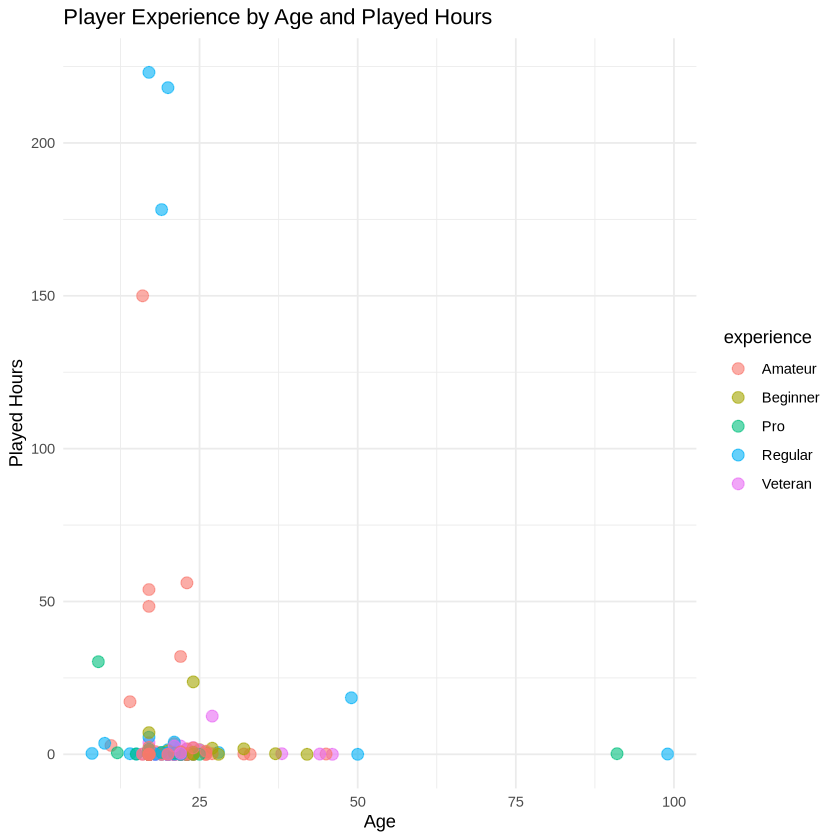

In [29]:


ggplot(players_final_count, aes(x = age, y = played_hours, color = experience)) +
  geom_point(size = 3, alpha = 0.6) +
  labs(title = "Player Experience by Age and Played Hours",
       x = "Age",
       y = "Played Hours") +
  theme_minimal()


In [30]:
players_final_transformed <- players_final |>
mutate(played_hours_log = log(played_hours + 1))
head(players_final_transformed)

,experience,subscribe,played_hours,gender,age,played_hours_log
,<chr>,<lgl>,<dbl>,<chr>,<int>,<dbl>
1,Pro,TRUE,30.3,Male,9,3.44361810
2,Veteran,TRUE,3.8,Male,17,1.56861592
3,Veteran,FALSE,0.0,Male,17,0.00000000
4,Amateur,TRUE,0.7,Female,21,0.53062825
5,Regular,TRUE,0.1,Male,21,0.09531018
6,Amateur,TRUE,0.0,Female,17,0.00000000


In [31]:
players_split <- initial_split(players_final_transformed, prop = 0.75, strata = experience)
players_train <- training(players_split)
players_test <- testing(players_split)
head(players_train)
dim(players_train)

,experience,subscribe,played_hours,gender,age,played_hours_log
,<chr>,<lgl>,<dbl>,<chr>,<int>,<dbl>
1,Amateur,TRUE,0.0,Female,17,0.00000000
2,Amateur,TRUE,0.1,Male,17,0.09531018
3,Amateur,TRUE,0.2,Male,22,0.18232156
4,Amateur,FALSE,0.0,Male,22,0.00000000
5,Amateur,TRUE,48.4,Female,17,3.89995042
6,Amateur,TRUE,0.5,Male,17,0.40546511


[1] 146   6

In [32]:
players_proportions <- players_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(players_train))

players_proportions

subscribe,n,percent
<lgl>,<int>,<dbl>
FALSE,32,21.91781
TRUE,114,78.08219


In [37]:
players_recipe <- recipe(subscribe ~ age + played_hours_log + subscribe + gender + experience, data = players_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors()) |>
  step_dummy(all_nominal_predictors()) |>
  step_novel(all_nominal_predictors())


In [38]:

# Ensure the target variable is a factor
players_train <- players_train %>%
  mutate(subscribe = as.factor(subscribe))  # Convert `subscribe` to a factor

# Update the recipe to explicitly handle the target variable
players_recipe <- recipe(subscribe ~ ., data = players_train) %>%
  step_dummy(all_nominal_predictors(), -all_outcomes()) %>%  # Convert categorical predictors
  step_center(all_numeric_predictors()) %>%                 # Center numeric predictors
  step_scale(all_numeric_predictors())                      # Scale numeric predictors

# Define the kNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_mode("classification") %>%
  set_engine("kknn")

# Fit the workflow with the corrected recipe and data
knn_fit <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = players_train)

knn_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2534247
Best kernel: rectangular
Best k: 5

In [39]:
validation_predicted <- predict(knn_fit, players_test) |>
  bind_cols(players_test)
head(validation_predicted)

.pred_class,experience,subscribe,played_hours,gender,age,played_hours_log
<fct>,<chr>,<lgl>,<dbl>,<chr>,<int>,<dbl>
TRUE,Pro,TRUE,30.3,Male,9,3.4436181
TRUE,Veteran,FALSE,0.0,Male,17,0.0000000
TRUE,Amateur,TRUE,0.7,Female,21,0.5306283
TRUE,Regular,TRUE,0.0,Female,19,0.0000000
TRUE,Amateur,FALSE,0.0,Male,21,0.0000000
TRUE,Veteran,TRUE,0.0,Female,22,0.0000000


In [41]:
# Ensure the `truth` column is a factor
validation_predicted <- validation_predicted %>%
  mutate(subscribe = as.factor(subscribe))  # Convert `subscribe` to a factor

# Compute accuracy
accuracy_result <- validation_predicted %>%
  accuracy(truth = subscribe, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

# View accuracy results
accuracy_result


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.64


In [42]:
precision_result <- validation_predicted |>
  precision(truth = subscribe, estimate = .pred_class)
precision_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6666667


In [43]:
recall_result <- validation_predicted |>
  recall(truth = subscribe, estimate = .pred_class)
recall_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.2


In [44]:
confusion_matrix_result <- validation_predicted |>
  conf_mat(truth = subscribe, estimate = .pred_class)
confusion_matrix_result

          Truth
Prediction FALSE TRUE
     FALSE     4    2
     TRUE     16   28

In [86]:
knn_spec_tune <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = tune()  # Now tuning k instead of fixed k=5
) %>%
  set_mode("classification") %>%
  set_engine("kknn")



# 2. Create cross-validation folds
players_folds <- vfold_cv(players_train, v = 5, strata = experience)

# 3. Create grid of k values to try
k_grid <- tibble(neighbors = seq(1, 30, by = 1))

# 4. Tune the model
knn_tuning <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec_tune) |>
  tune_grid(
    resamples = players_folds,
    grid = k_grid
  )

# 5. View best k value
show_best(knn_tuning, metric = "accuracy")

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
→ A | error:   Error in `step_rm()`:
               Caused by error in `prep()`:
               ℹ In argument: `all_of(c("gender", "subscribe"))`.
               Caused by error in `all_of()`:
               ! Can't subset elements that don't exist.
               ✖ Elements `gender` and `subscribe` don't exist.

There were issues with some computations   A: x1

There were issues with some computations   A: x4

There were issues with some computations   A: x5



Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in `estimate_tune_results()`:[22m
[33m![39m All models failed. Run `show_notes(.Last.tune.result)` for more information.


In [46]:
best_k <- show_best(knn_tuning, metric = "accuracy") %>%
  slice(1) %>%
  pull(neighbors)

# Retrain the model with the best k
knn_spec_final <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = best_k
) %>%
  set_mode("classification") %>%
  set_engine("kknn")

# Retrain the workflow with the best k
final_knn_workflow <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(knn_spec_final)

# Fit the final model
final_knn_fit <- final_knn_workflow %>%
  fit(data = players_train)
final_knn_fit 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2328767
Best kernel: rectangular
Best k: 11

In [49]:

test_predictions <- final_knn_fit %>%
  predict(new_data = players_test) %>%
  bind_cols(players_test) %>%
  mutate(
    subscribe = as.factor(subscribe),     # Convert binary outcome to factor
    .pred_class = as.factor(.pred_class) # Convert predictions to factor
  )

# Evaluate performance using the confusion matrix
confusion_matrix <- test_predictions %>%
  conf_mat(truth = subscribe, estimate = .pred_class)  # Use `subscribe` as truth

# Display the confusion matrix
confusion_matrix

# Calculate additional performance metrics
metrics <- test_predictions %>%
  metrics(truth = subscribe, estimate = .pred_class)  # Use `subscribe` as truth

# View the metrics
metrics


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     20   30

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6
kap,binary,0.0


In [81]:
players_train_smote <- players_train %>%
  step_smote(experience, over_ratio = 1) %>%  # Adjust over-sampling ratio if needed
  prep(training = players_train) %>%
  bake(new_data = NULL)

# Step 2: Create new tuning grid with larger k values (1 to 30)
k_grid <- tibble(neighbors = seq(1, 30, by = 2))

# Step 3: Define the k-NN model with a different distance metric and tune `k`
knn_spec_tune <- nearest_neighbor(
  weight_func = "rectangular",  # You can change this to other options like 'gaussian'
  neighbors = tune(),           # Tuning `k`
  distance_metric = "euclidean" # Change distance metric from default if needed
) %>%
  set_mode("classification") %>%
  set_engine("kknn")

# Step 4: Create 5-fold cross-validation folds
players_folds <- vfold_cv(players_train_smote, v = 5, strata = experience)

# Step 5: Tune the model with a larger range of k values
knn_tuning <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(knn_spec_tune) %>%
  tune_grid(
    resamples = players_folds,
    grid = k_grid
  )

# Step 6: View the best `k` based on accuracy
show_best(knn_tuning, metric = "accuracy")

# Step 7: Evaluate performance on the test set
final_model <- finalize_model(knn_spec_tune, select_best(knn_tuning, metric = "accuracy"))
final_workflow <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(final_model)

final_results <- final_workflow %>%
  fit(data = players_train_smote) %>%
  predict(new_data = players_test) %>%
  bind_cols(players_test) %>%
  metrics(truth = experience, estimate = .pred_class)

# Print final results (accuracy, precision, recall, etc.)
final_results

Warning message:
“Unknown or uninitialised column: `steps`.”
Warning message:
“Unknown or uninitialised column: `steps`.”


ERROR: Error in UseMethod("prep"): no applicable method for 'prep' applied to an object of class "c('tbl_df', 'tbl', 'data.frame')"
